In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, plot_confusion_matrix, accuracy_score, \
    plot_roc_curve, plot_precision_recall_curve, classification_report, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [55]:
# загружаем данные полученные в EDA+FE
data_mod = pd.read_csv('mod_data/data_mod.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [56]:
# датафрейм для записи результатов
report_df = pd.DataFrame()

def get_scores(report_df, model, X_test, y_test, name):
    '''Принимает на вход датафрейм, обученную модель и данные с отложенной выборки, 
    рассчитывает метрики и записывает результаты в датафрейм'''
    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc_score(y_test,
                                      model.predict_proba(X_test)[:, 1])
    report['F1'] = f1_score(y_test, model.predict(X_test))
    report['precision_0'] = precision_score(
        y_test, model.predict(X_test), pos_label=0)
    report['precision_1'] = precision_score(
        y_test, model.predict(X_test), pos_label=1)
    report['recall_0'] = recall_score(
        y_test, model.predict(X_test), pos_label=0)
    report['recall_1'] = recall_score(
        y_test, model.predict(X_test), pos_label=1)
    report['accuracy'] = accuracy_score(
        y_test, model.predict(X_test))
    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [57]:
data_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  200000 non-null  int64  
 1   Survived     100000 non-null  float64
 2   Pclass       200000 non-null  int64  
 3   Name         200000 non-null  object 
 4   Sex          200000 non-null  object 
 5   Age          200000 non-null  float64
 6   SibSp        200000 non-null  int64  
 7   Parch        200000 non-null  int64  
 8   Ticket       200000 non-null  object 
 9   Fare         200000 non-null  float64
 10  Embarked     200000 non-null  object 
 11  Deck         200000 non-null  object 
 12  Family       200000 non-null  int64  
 13  Alone        200000 non-null  bool   
 14  FareC        200000 non-null  object 
 15  AgeC         200000 non-null  object 
dtypes: bool(1), float64(3), int64(5), object(7)
memory usage: 23.1+ MB


# Features selection & encoding

In [58]:
label_cols = ['Name', 'Ticket', 'Family', 'Alone']
onehot_cols = ['Pclass', 'Sex', 'Deck', 'Embarked']
numerical_cols = ['Age', 'Fare', 'Survived']

In [59]:
def label_encoder(c):
    lc = LabelEncoder()
    return lc.fit_transform(c)

In [60]:
onehot_encoded_df = pd.get_dummies(data_mod[onehot_cols])
label_encoded_df = data_mod[label_cols].apply(label_encoder)
numerical_df = data_mod[numerical_cols]

In [61]:
data = pd.concat([numerical_df, label_encoded_df, onehot_encoded_df], axis=1)

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Age         200000 non-null  float64
 1   Fare        200000 non-null  float64
 2   Survived    100000 non-null  float64
 3   Name        200000 non-null  int64  
 4   Ticket      200000 non-null  int64  
 5   Family      200000 non-null  int64  
 6   Alone       200000 non-null  int64  
 7   Pclass      200000 non-null  int64  
 8   Sex_female  200000 non-null  uint8  
 9   Sex_male    200000 non-null  uint8  
 10  Deck_A      200000 non-null  uint8  
 11  Deck_B      200000 non-null  uint8  
 12  Deck_C      200000 non-null  uint8  
 13  Deck_D      200000 non-null  uint8  
 14  Deck_E      200000 non-null  uint8  
 15  Deck_F      200000 non-null  uint8  
 16  Deck_G      200000 non-null  uint8  
 17  Deck_N      200000 non-null  uint8  
 18  Deck_T      200000 non-null  uint8  
 19  Em

### Split data

In [63]:
# разделяем общий дадасет data на train и test
# в тестовый датасет попадают только те объекты для которых значение 'Survived' не определено
predict_data = data[data['Survived'].isnull()]
predict_data = predict_data.drop(['Survived'], axis = 1)

# в тренировачный набор попадают объекты у которых нет пропущеных значений ни у одной переменной
train_data = data.dropna()
target = train_data['Survived']
train_data = train_data.drop(['Survived'], axis = 1)
# контроль разммера
train_data.shape

(100000, 21)

# Random Forest model

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
# разделяем на отложенную и ообучающую
X_train, X_test, y_train, y_test = train_test_split(train_data, target, 
                                                    test_size=0.2, 
                                                    random_state=23)

In [66]:
rf = RandomForestClassifier()
rf_params = {
    'bootstrap': [True,False],
    'n_estimators': [600,1000,2000,3000],
    'min_samples_split': [2,3,5,7],
    'min_samples_leaf': [8,10,12]
}
# подбор гиперпараметров
rf_rand = RandomizedSearchCV(rf, rf_params, cv=3, verbose=5, n_jobs=-1, n_iter=5, random_state=54, scoring = "accuracy")
rf_rand.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  6.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'min_samples_leaf': [8, 10, 12],
                                        'min_samples_split': [2, 3, 5, 7],
                                        'n_estimators': [600, 1000, 2000,
                                                         3000]},
                   random_state=54, verbose=5)

In [67]:
# лучший score и лучшие параметры на кросс-валидации
print("Accuracy (random forest auto): {} params {}"
      .format(rf_rand.best_score_, rf_rand.best_params_))
# записываем результаты на отложенной выборке в датафрейм
report_df = get_scores(report_df, rf_rand, X_test,
                       y_test, 'Random_Forest')

Accuracy (random forest auto): 0.7789624939933507 params {'n_estimators': 3000, 'min_samples_split': 7, 'min_samples_leaf': 10, 'bootstrap': True}


In [68]:
report_df

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1,accuracy
Random_Forest,0.854359,0.748335,0.807365,0.75767,0.822148,0.739227,0.78655


# Logistic Regression model

In [69]:
from sklearn.linear_model import LogisticRegression

In [70]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target, 
                                                    test_size=0.2, 
                                                    random_state=23)

In [71]:
lr = LogisticRegression()
lr_params = {
    'C': np.linspace(0.001, 10, 20), 
    'penalty': ['l1', 'l2']
}
# подбор гиперпараметров
lr_rand = RandomizedSearchCV(lr, lr_params, cv=5, verbose=5, n_jobs=-1, n_iter=20, random_state=54, scoring = "accuracy")
lr_rand.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.9s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 5.27263158e-01, 1.05352632e+00, 1.57978947e+00,
       2.10605263e+00, 2.63231579e+00, 3.15857895e+00, 3.68484211e+00,
       4.21110526e+00, 4.73736842e+00, 5.26363158e+00, 5.78989474e+00,
       6.31615789e+00, 6.84242105e+00, 7.36868421e+00, 7.89494737e+00,
       8.42121053e+00, 8.94747368e+00, 9.47373684e+00, 1.00000000e+01]),
                                        'penalty': ['l1', 'l2']},
                   random_state=54, scoring='accuracy', verbose=5)

In [72]:
# лучший score и лучшие параметры на кросс-валидации
print("Accuracy (random forest auto): {} params {}"
      .format(lr_rand.best_score_, lr_rand.best_params_))
# записываем результаты на отложенной выборке в датафрейм
report_df = get_scores(report_df, lr_rand, X_test,
                       y_test, 'Logistic_Regression')

Accuracy (random forest auto): 0.7605999999999999 params {'penalty': 'l2', 'C': 8.947473684210527}


In [73]:
report_df

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1,accuracy
Random_Forest,0.854359,0.748335,0.807365,0.757670,0.822148,0.739227,0.78655
Logistic_Regression,0.818090,0.676340,0.745805,0.745511,0.841072,0.618915,0.74570


# LightGBM model

In [74]:
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [75]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target, 
                                                    test_size=0.2, 
                                                    random_state=23)

In [76]:
lgbc = lgb.LGBMClassifier()
lgbc_params = {
             'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=2), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'scale_pos_weight':[1,2,6,12],
             'metric':'binary_logloss',
             'n_estimators': [100, 250, 500, 1000]
}
lgbc_rand = RandomizedSearchCV(lgbc, lgbc_params, cv=5, verbose=5, n_jobs=-1, n_iter=20, random_state=54, scoring = 'accuracy')
lgbc_rand.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.2s finished


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4d3185a130>,
                                        'metric': 'binary_logloss',
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4d31842ca0>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 100...
                                                             10000.0],
                                        'n_estimators': [100, 250, 500, 1000],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4d31842940>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
       

In [77]:
# лучший score и параметры на кросс-валидации
print("Accuracy (random forest auto): {} params {}"
      .format(lgbc_rand.best_score_, lgbc_rand.best_params_))
# записываем результаты на отложенной выборке в датафрейм
report_df = get_scores(report_df, lgbc_rand, X_test,
                       y_test, 'LGBM')

Accuracy (random forest auto): 0.777425 params {'colsample_bytree': 0.988449664619988, 'metric': 'a', 'min_child_samples': 186, 'min_child_weight': 0.1, 'n_estimators': 500, 'num_leaves': 32, 'reg_alpha': 0.1, 'reg_lambda': 50, 'scale_pos_weight': 1, 'subsample': 0.39137782306411545}


In [78]:
report_df

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1,accuracy
Random_Forest,0.854359,0.748335,0.807365,0.757670,0.822148,0.739227,0.78655
Logistic_Regression,0.818090,0.676340,0.745805,0.745511,0.841072,0.618915,0.74570
LGBM,0.853518,0.748131,0.807623,0.756278,0.820571,0.740158,0.78605


# XGBoost

In [82]:
import xgboost as xgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [83]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target, 
                                                    test_size=0.2, 
                                                    random_state=23)

In [86]:
xgbc = xgb.XGBClassifier( tree_method = "exact", predictor = "cpu_predictor", verbosity = 1,
                           eval_metric = "logloss", objective = "binary:logistic")
# Create parameter grid
xgbc_params = {
               "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
               "gamma" : [0.3, 0.5, 1, 1.5, 2, 3, 4],
               "max_depth": [3, 4, 5, 6, 10],
               "colsample_bytree": sp_uniform(loc=0.2, scale=1),
               "subsample": sp_uniform(loc=0.2, scale=2),
               "reg_alpha": [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
               "reg_lambda": [0, 1e-1, 1, 5, 10, 20, 50, 100],
               "min_child_weight": [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
               "n_estimators": [100, 250, 500, 1000]
}

# Create RandomizedSearchCV Object
xgbc_rand = RandomizedSearchCV(xgbc, param_distributions = xgbc_params, scoring = "accuracy",
                             cv = 5, verbose = 3, random_state = 40)
# Fit the model
model_xgboost = xgbc_rand.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] colsample_bytree=0.6076870280802862, gamma=3, learning_rate=0.01, max_depth=3, min_child_weight=0.01, n_estimators=250, reg_alpha=50, reg_lambda=1, subsample=0.46815963575839287 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.6076870280802862, gamma=3, learning_rate=0.01, max_depth=3, min_child_weight=0.01, n_estimators=250, reg_alpha=50, reg_lambda=1, subsample=0.46815963575839287, score=0.774, total=   3.5s
[CV] colsample_bytree=0.6076870280802862, gamma=3, learning_rate=0.01, max_depth=3, min_child_weight=0.01, n_estimators=250, reg_alpha=50, reg_lambda=1, subsample=0.46815963575839287 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV]  colsample_bytree=0.6076870280802862, gamma=3, learning_rate=0.01, max_depth=3, min_child_weight=0.01, n_estimators=250, reg_alpha=50, reg_lambda=1, subsample=0.46815963575839287, score=0.773, total=   2.8s
[CV] colsample_bytree=0.6076870280802862, gamma=3, learning_rate=0.01, max_depth=3, min_child_weight=0.01, n_estimators=250, reg_alpha=50, reg_lambda=1, subsample=0.46815963575839287 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s


[CV]  colsample_bytree=0.6076870280802862, gamma=3, learning_rate=0.01, max_depth=3, min_child_weight=0.01, n_estimators=250, reg_alpha=50, reg_lambda=1, subsample=0.46815963575839287, score=0.778, total=   3.0s
[CV] colsample_bytree=0.6076870280802862, gamma=3, learning_rate=0.01, max_depth=3, min_child_weight=0.01, n_estimators=250, reg_alpha=50, reg_lambda=1, subsample=0.46815963575839287 
[CV]  colsample_bytree=0.6076870280802862, gamma=3, learning_rate=0.01, max_depth=3, min_child_weight=0.01, n_estimators=250, reg_alpha=50, reg_lambda=1, subsample=0.46815963575839287, score=0.770, total=   2.7s
[CV] colsample_bytree=0.6076870280802862, gamma=3, learning_rate=0.01, max_depth=3, min_child_weight=0.01, n_estimators=250, reg_alpha=50, reg_lambda=1, subsample=0.46815963575839287 
[CV]  colsample_bytree=0.6076870280802862, gamma=3, learning_rate=0.01, max_depth=3, min_child_weight=0.01, n_estimators=250, reg_alpha=50, reg_lambda=1, subsample=0.46815963575839287, score=0.775, total=   2

[CV]  colsample_bytree=0.7083099649576006, gamma=2, learning_rate=0.05, max_depth=6, min_child_weight=0.1, n_estimators=500, reg_alpha=1, reg_lambda=100, subsample=0.7675145143612605, score=0.779, total=   8.2s
[CV] colsample_bytree=0.7083099649576006, gamma=2, learning_rate=0.05, max_depth=6, min_child_weight=0.1, n_estimators=500, reg_alpha=1, reg_lambda=100, subsample=0.7675145143612605 
[CV]  colsample_bytree=0.7083099649576006, gamma=2, learning_rate=0.05, max_depth=6, min_child_weight=0.1, n_estimators=500, reg_alpha=1, reg_lambda=100, subsample=0.7675145143612605, score=0.782, total=   8.3s
[CV] colsample_bytree=0.9609369457853925, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=0.1, n_estimators=1000, reg_alpha=100, reg_lambda=100, subsample=0.5749625462813173 
[CV]  colsample_bytree=0.9609369457853925, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=0.1, n_estimators=1000, reg_alpha=100, reg_lambda=100, subsample=0.5749625462813173, score=0.777, total= 

[CV]  colsample_bytree=0.8095896671142067, gamma=4, learning_rate=0.01, max_depth=6, min_child_weight=0.01, n_estimators=500, reg_alpha=5, reg_lambda=0.1, subsample=0.7131997918663675, score=0.777, total=  14.2s
[CV] colsample_bytree=0.8095896671142067, gamma=4, learning_rate=0.01, max_depth=6, min_child_weight=0.01, n_estimators=500, reg_alpha=5, reg_lambda=0.1, subsample=0.7131997918663675 
[CV]  colsample_bytree=0.8095896671142067, gamma=4, learning_rate=0.01, max_depth=6, min_child_weight=0.01, n_estimators=500, reg_alpha=5, reg_lambda=0.1, subsample=0.7131997918663675, score=0.778, total=  12.9s
[CV] colsample_bytree=0.8095896671142067, gamma=4, learning_rate=0.01, max_depth=6, min_child_weight=0.01, n_estimators=500, reg_alpha=5, reg_lambda=0.1, subsample=0.7131997918663675 
[CV]  colsample_bytree=0.8095896671142067, gamma=4, learning_rate=0.01, max_depth=6, min_child_weight=0.01, n_estimators=500, reg_alpha=5, reg_lambda=0.1, subsample=0.7131997918663675, score=0.783, total=  14

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.2min finished


In [87]:
# лучший score и параметры на кросс-валидации
print("Accuracy (random forest auto): {} params {}"
      .format(xgbc_rand.best_score_, xgbc_rand.best_params_))
# записываем результаты на отложенной выборке в датафрейм
report_df = get_scores(report_df, xgbc_rand, X_test,
                       y_test, 'XGB')

Accuracy (random forest auto): 0.780375 params {'colsample_bytree': 0.7083099649576006, 'gamma': 2, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 0.1, 'n_estimators': 500, 'reg_alpha': 1, 'reg_lambda': 100, 'subsample': 0.7675145143612605}


In [121]:
report_df

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1,accuracy
Random_Forest,0.854359,0.748335,0.807365,0.757670,0.822148,0.739227,0.78655
Logistic_Regression,0.818090,0.676340,0.745805,0.745511,0.841072,0.618915,0.74570
LGBM,0.853518,0.748131,0.807623,0.756278,0.820571,0.740158,0.78605
XGB,0.855948,0.747596,0.806671,0.757380,0.822148,0.738062,0.78605


# Feature importances

In [119]:
xgbc_ = xgb.XGBClassifier(eval_metric = "logloss", objective = "binary:logistic", 
                          colsample_bytree = 0.7083099649576006, gamma = 2, learning_rate = 0.05, 
                          max_depth = 6, min_child_weight = 0.1, n_estimators = 500, reg_alpha = 1, 
                          reg_lambda = 100, subsample = 0.7675145143612605)
xgbc_.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7083099649576006,
              eval_metric='logloss', gamma=2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=0.1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=1, reg_lambda=100,
              scale_pos_weight=1, subsample=0.7675145143612605,
              tree_method='exact', validate_parameters=1, verbosity=None)

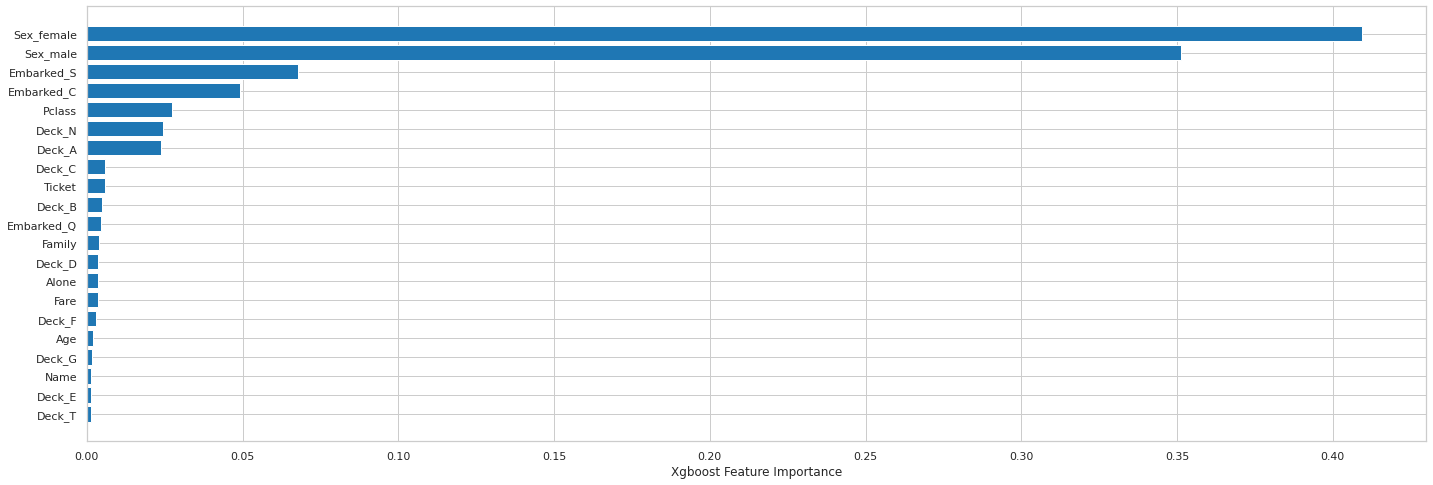

In [120]:
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (24,8)

sorted_idx = xgbc_.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgbc_.feature_importances_[sorted_idx], ecolor='g')
plt.xlabel("Xgboost Feature Importance");


In [122]:
# делаем прогноз лучшей моделью
pred = xgbc_.predict_proba(predict_data)

In [123]:
# отправляем посылку на Кегл
submission['Survived'] = ((pred) < 0.5).astype(int)
submission.to_csv('predict_xgb.csv', index = False)